In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

# Konfigurasi Konstanta
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 40
DATA_DIR = 'dataset/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

TensorFlow Version: 2.20.0


In [4]:
# Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load Test Data (Data yang benar-benar asing bagi model)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
print("Kelas Emosi:", class_names)

Found 20000 files belonging to 5 classes.
Using 16000 files for training.
Found 20000 files belonging to 5 classes.
Using 4000 files for validation.
Found 20000 files belonging to 5 classes.
Kelas Emosi: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [5]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

# Optimasi Data Loading (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds, augment=False)
test_ds = prepare(test_ds, augment=False)

In [6]:
base_model = applications.EfficientNetB0(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(len(class_names), activation='softmax')(x) 

model = models.Model(inputs, outputs, name="Emotion_EfficientNet_Corrected")

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "Emotion_EfficientNet_Corrected"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,936 (16.73 MB)

 Trainable params: 332,293 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [7]:
# Definisi Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_emotion_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping_cb = callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_loss'
)
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
)

print("Mulai Training Tahap 1 (Top Layers Only)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Mulai Training Tahap 1 (Top Layers Only)...
Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 266s 521ms/step - accuracy: 0.3950 - loss: 1.6196 - val_accuracy: 0.5102 - val_loss: 1.1729 - learning_rate: 0.0010
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 252s 503ms/step - accuracy: 0.4686 - loss: 1.2812 - val_accuracy: 0.5295 - val_loss: 1.1355 - learning_rate: 0.0010
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 274s 549ms/step - accuracy: 0.4924 - loss: 1.2206 - val_accuracy: 0.5428 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 276s 551ms/step - accuracy: 0.5027 - loss: 1.1994 - val_accuracy: 0.5562 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 277s 554ms/step - accuracy: 0.5128 - loss: 1.1770 - val_accuracy: 0.5550 - val_loss: 1.0928 - learning_rate: 0.0010
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 268s 537ms/step - accuracy: 0.5246 - loss: 1.1552 - val_accuracy: 0.5485 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 7/15
500/500 ━

In [9]:
model = models.load_model('best_emotion_model.keras')

base_model = model.layers[1] 
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_list_aggressive = [
    callbacks.ModelCheckpoint("best_emotion_model_v2.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True), # Lebih sabar (8 epoch)
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6) # Turunnya pelan2 (0.5)
]

print("\nTraining Tahap 2 (Fine-Tuning)...")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    initial_epoch=history.epoch[-1],
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


Training Tahap 2 (Fine-Tuning)...
Epoch 15/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 300s 584ms/step - accuracy: 0.4545 - loss: 1.3497 - val_accuracy: 0.5573 - val_loss: 1.0856 - learning_rate: 3.0000e-05
Epoch 16/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 630ms/step - accuracy: 0.5217 - loss: 1.1669 - val_accuracy: 0.5865 - val_loss: 1.0214 - learning_rate: 3.0000e-05
Epoch 17/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - accuracy: 0.5633 - loss: 1.0696 - val_accuracy: 0.5990 - val_loss: 0.9826 - learning_rate: 3.0000e-05
Epoch 18/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 350s 700ms/step - accuracy: 0.5924 - loss: 1.0054 - val_accuracy: 0.6140 - val_loss: 0.9553 - learning_rate: 3.0000e-05
Epoch 19/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 366s 733ms/step - accuracy: 0.6131 - loss: 0.9558 - val_accuracy: 0.6215 - val_loss: 0.9407 - learning_rate: 3.0000e-05
Epoch 20/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 359s 717ms/step - accuracy: 0.6340 - loss: 0.9101 - val_accuracy: 0.6332 - val_loss: 0.9217 - learning_rate: 3.0000e-05

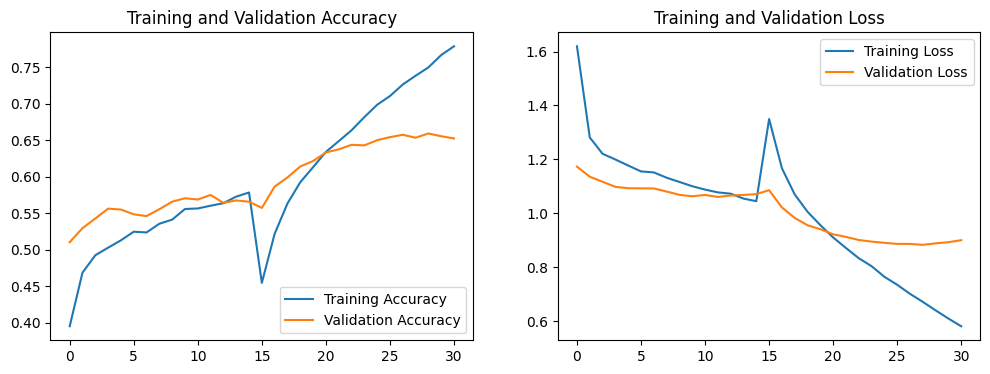


Evaluasi pada Test Set:
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 350ms/step - accuracy: 0.6629 - loss: 0.8546
Test Accuracy: 66.29%


2025-12-09 11:42:39.344741: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


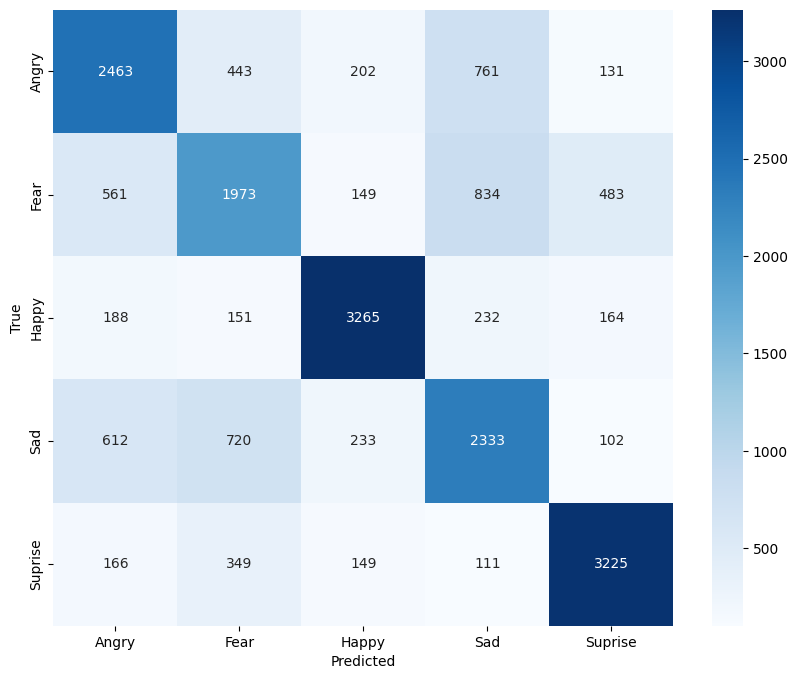

              precision    recall  f1-score   support

       Angry       0.62      0.62      0.62      4000
        Fear       0.54      0.49      0.52      4000
       Happy       0.82      0.82      0.82      4000
         Sad       0.55      0.58      0.56      4000
     Suprise       0.79      0.81      0.80      4000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000



In [10]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("\nEvaluasi pada Test Set:")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_true = []
y_pred = []

for x, y in test_ds:
    predictions = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))